In [ ]:
"""
File Name: ex10_cae_anamaly_detector_v2_cbc.ipynb

Description: anomaly detection using cae_sd for statistical features

Author: junghwan lee
Email: jhrrlee@gmail.com
Date Created: 2023.10.14
"""

In [1]:
import sys
#from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

2025-03-06 01:20:48.100428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 01:20:48.151507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 01:20:54.925927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/d/sandbox/optimal_rul/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

In [19]:
"""
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/dnn_models/')
data_path = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/resource/dataset/'
base_dir = '/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/preprocessing/cae/'
"""


'\ndrive.mount("/content/drive", force_remount=True)\nsys.path.append(\'/content/drive/MyDrive/Colab_Notebooks\')\nsys.path.append(\'/content/drive/MyDrive/Colab_Notebooks/toyota_data\')\nsys.path.append(\'/content/drive/MyDrive/Colab_Notebooks/toyota_data\')\nsys.path.append(\'/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/dnn_models/\')\ndata_path = \'/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/resource/dataset/\'\nbase_dir = \'/content/drive/MyDrive/Colab_Notebooks/toyota_data/RUL_ML_Framework/preprocessing/cae/\'\n'

In [2]:
import importlib

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-03-06 01:21:10.433102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:10.433217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:10.523387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:10.523441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:10.523464: I external/local_xla/xla/stream_executor

In [5]:
import os

current_dir = os.getcwd()
print("Current Project Directory:", current_dir)


Current Project Directory: /mnt/d/sandbox/optimal_rul/data_analysis/p3_anomaly_detection/ex10


In [5]:
sys.path.append('../')
sys.path.append('../../../auto_encoder/')
gen_path = '../../../resource/dataset/'
proj_dir = "/mnt/d/sandbox/optimal_rul"  # Change this to your actual project path
sys.path.append(proj_dir)
base_dir = './cae/'

In [6]:
from cae import create_cae_v1,  create_cae_v2,  create_cae_v3

In [7]:
import AnomalyDetector as AD
from AnomalyDetector import BatData, AutoencoderTrainer, AnomalyDetector
importlib.reload(AD)

<module 'AnomalyDetector' from '/mnt/d/sandbox/optimal_rul/data_analysis/p3_anomaly_detection/ex10/../AnomalyDetector.py'>

In [8]:
eol = np.load(gen_path + 'eol_21_120.npy')
cycle_data = np.load(gen_path + 'interpolated_cycle_data_21_120.npy')

In [9]:
cycle_count = np.arange(1, cycle_data.shape[1]+1)

num_cells = eol.shape[0]
num_cycles = cycle_count.shape[0]

# Repeat the EOL values for each cycle in the cycle_count array
eol_repeated = np.tile(eol, (1, num_cycles))

# Repeat the cycle_count values for each cell in the cycle_count array
cycle_count_repeated = np.tile(cycle_count, (num_cells, 1))

RUL_repeated = eol_repeated - cycle_count_repeated

print("RUL_repeated shape:", RUL_repeated.shape)
print("eol shape:", eol_repeated.shape)
print("cycle_count shape:", cycle_count_repeated.shape)
print("cycle_data shape:", cycle_data.shape)

RUL_repeated shape: (124, 100)
eol shape: (124, 100)
cycle_count shape: (124, 100)
cycle_data shape: (124, 100, 8, 1000)


In [10]:
import tensorflow as tf
def mape(y_true, y_pred):
    epsilon = 1e-9  # Adding a small constant to avoid division by zero
    error = (y_true - y_pred) / (tf.abs(y_true) + epsilon)
    return 100.0 * tf.reduce_mean(tf.abs(error))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


In [11]:
batdata = BatData(np.transpose(cycle_data, (0, 1, 3, 2)))

In [12]:
batdata.get_shape()

(124, 100, 1000, 8)

In [13]:
cae_v1_ae, cae_v1_encoder = create_cae_v1(1000, 8)

no_of_timeseries: 1000
no_of_features: 8


2025-03-06 01:21:18.820999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:18.821153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:18.821246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:18.821281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 01:21:18.821302: I external/local_xla/xla/stream_executor

In [14]:
cae_v1_ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 100, 8)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 10, 8)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 8)          │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 1, 8)           │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 8)          │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1000, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1000, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,080 (15.94 KB)

 Trainable params: 3,984 (15.56 KB)

 Non-trainable params: 96 (384.00 B)

In [104]:
!pip install pydot

In [20]:
import tensorflow.keras.utils as keras_utils
importlib.reload(keras_utils)
from tensorflow.keras.utils import plot_model

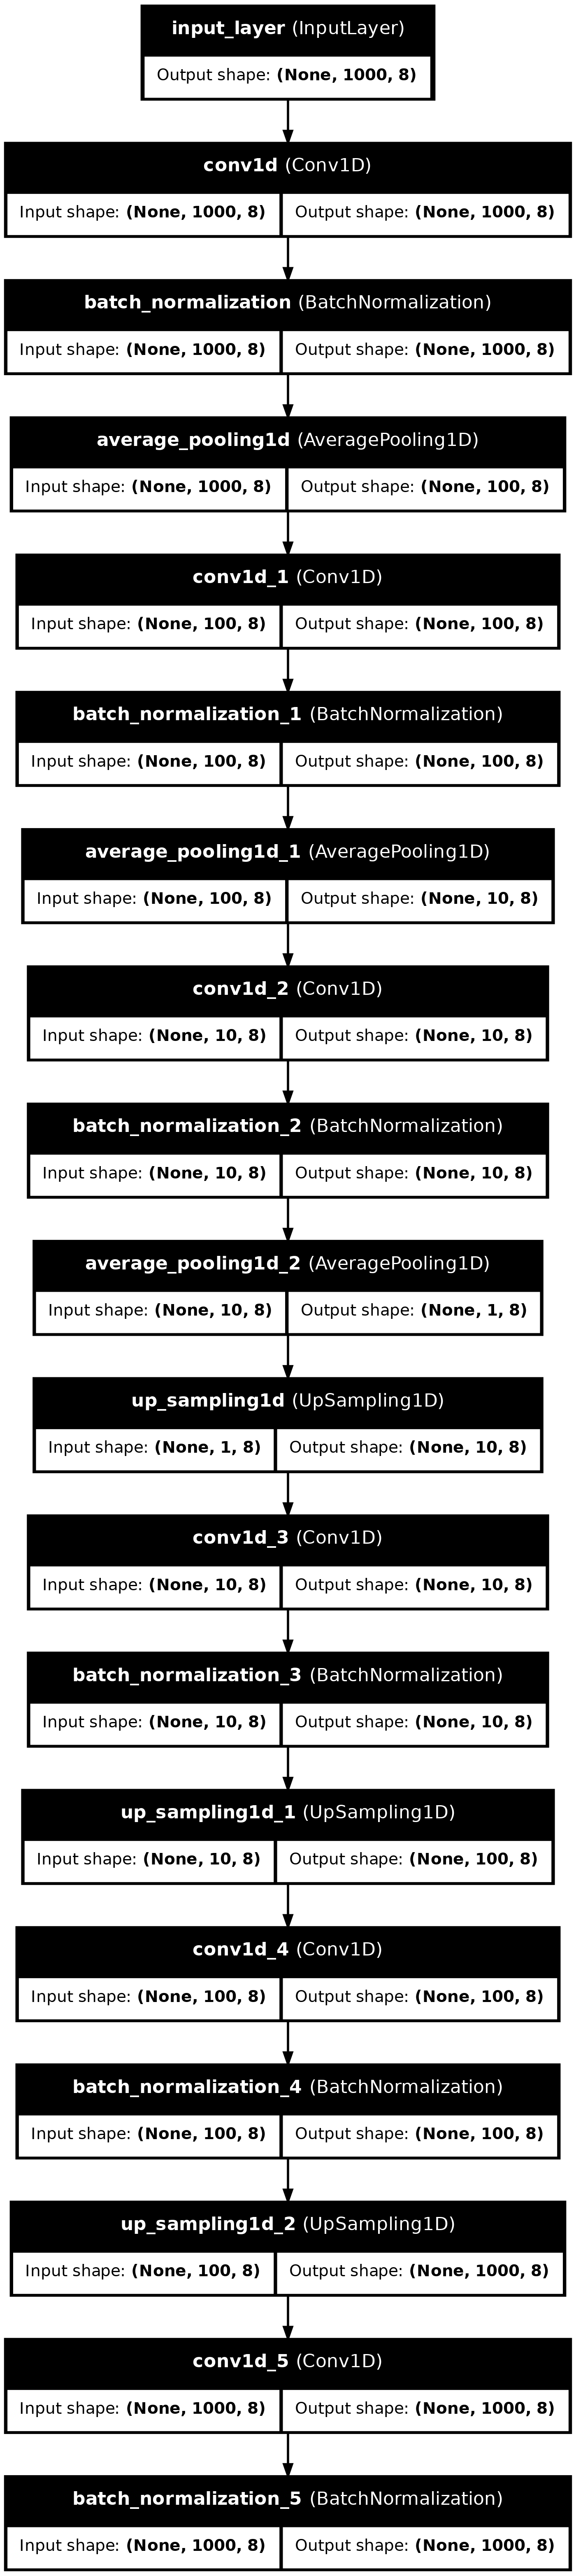

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(cae_v1_ae, to_file='cae_v1_ae_architecture.png', show_shapes=True, show_layer_names=True)

In [94]:
from IPython.display import Image, display
display(Image(filename='cae_v3_ae_architecture.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'cae_v3_ae_architecture.png'

In [41]:
cae_v1 = AutoencoderTrainer(base_dir, 'create_cae_v1_t1', batdata, cae_v1_ae)

In [ ]:
cae_v1.train(learning_rate = 0.0001, batch_size=64, max_epoch=300, no_patience=20)

In [85]:
cae_v1_average_error_metrics_by_cells = cae_v1.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.781278371810913 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[  0  14  39  41  42  43  44  47  48  53  54  55  60  61  76  77  78  79
  80  82  83  88  89 104 110]


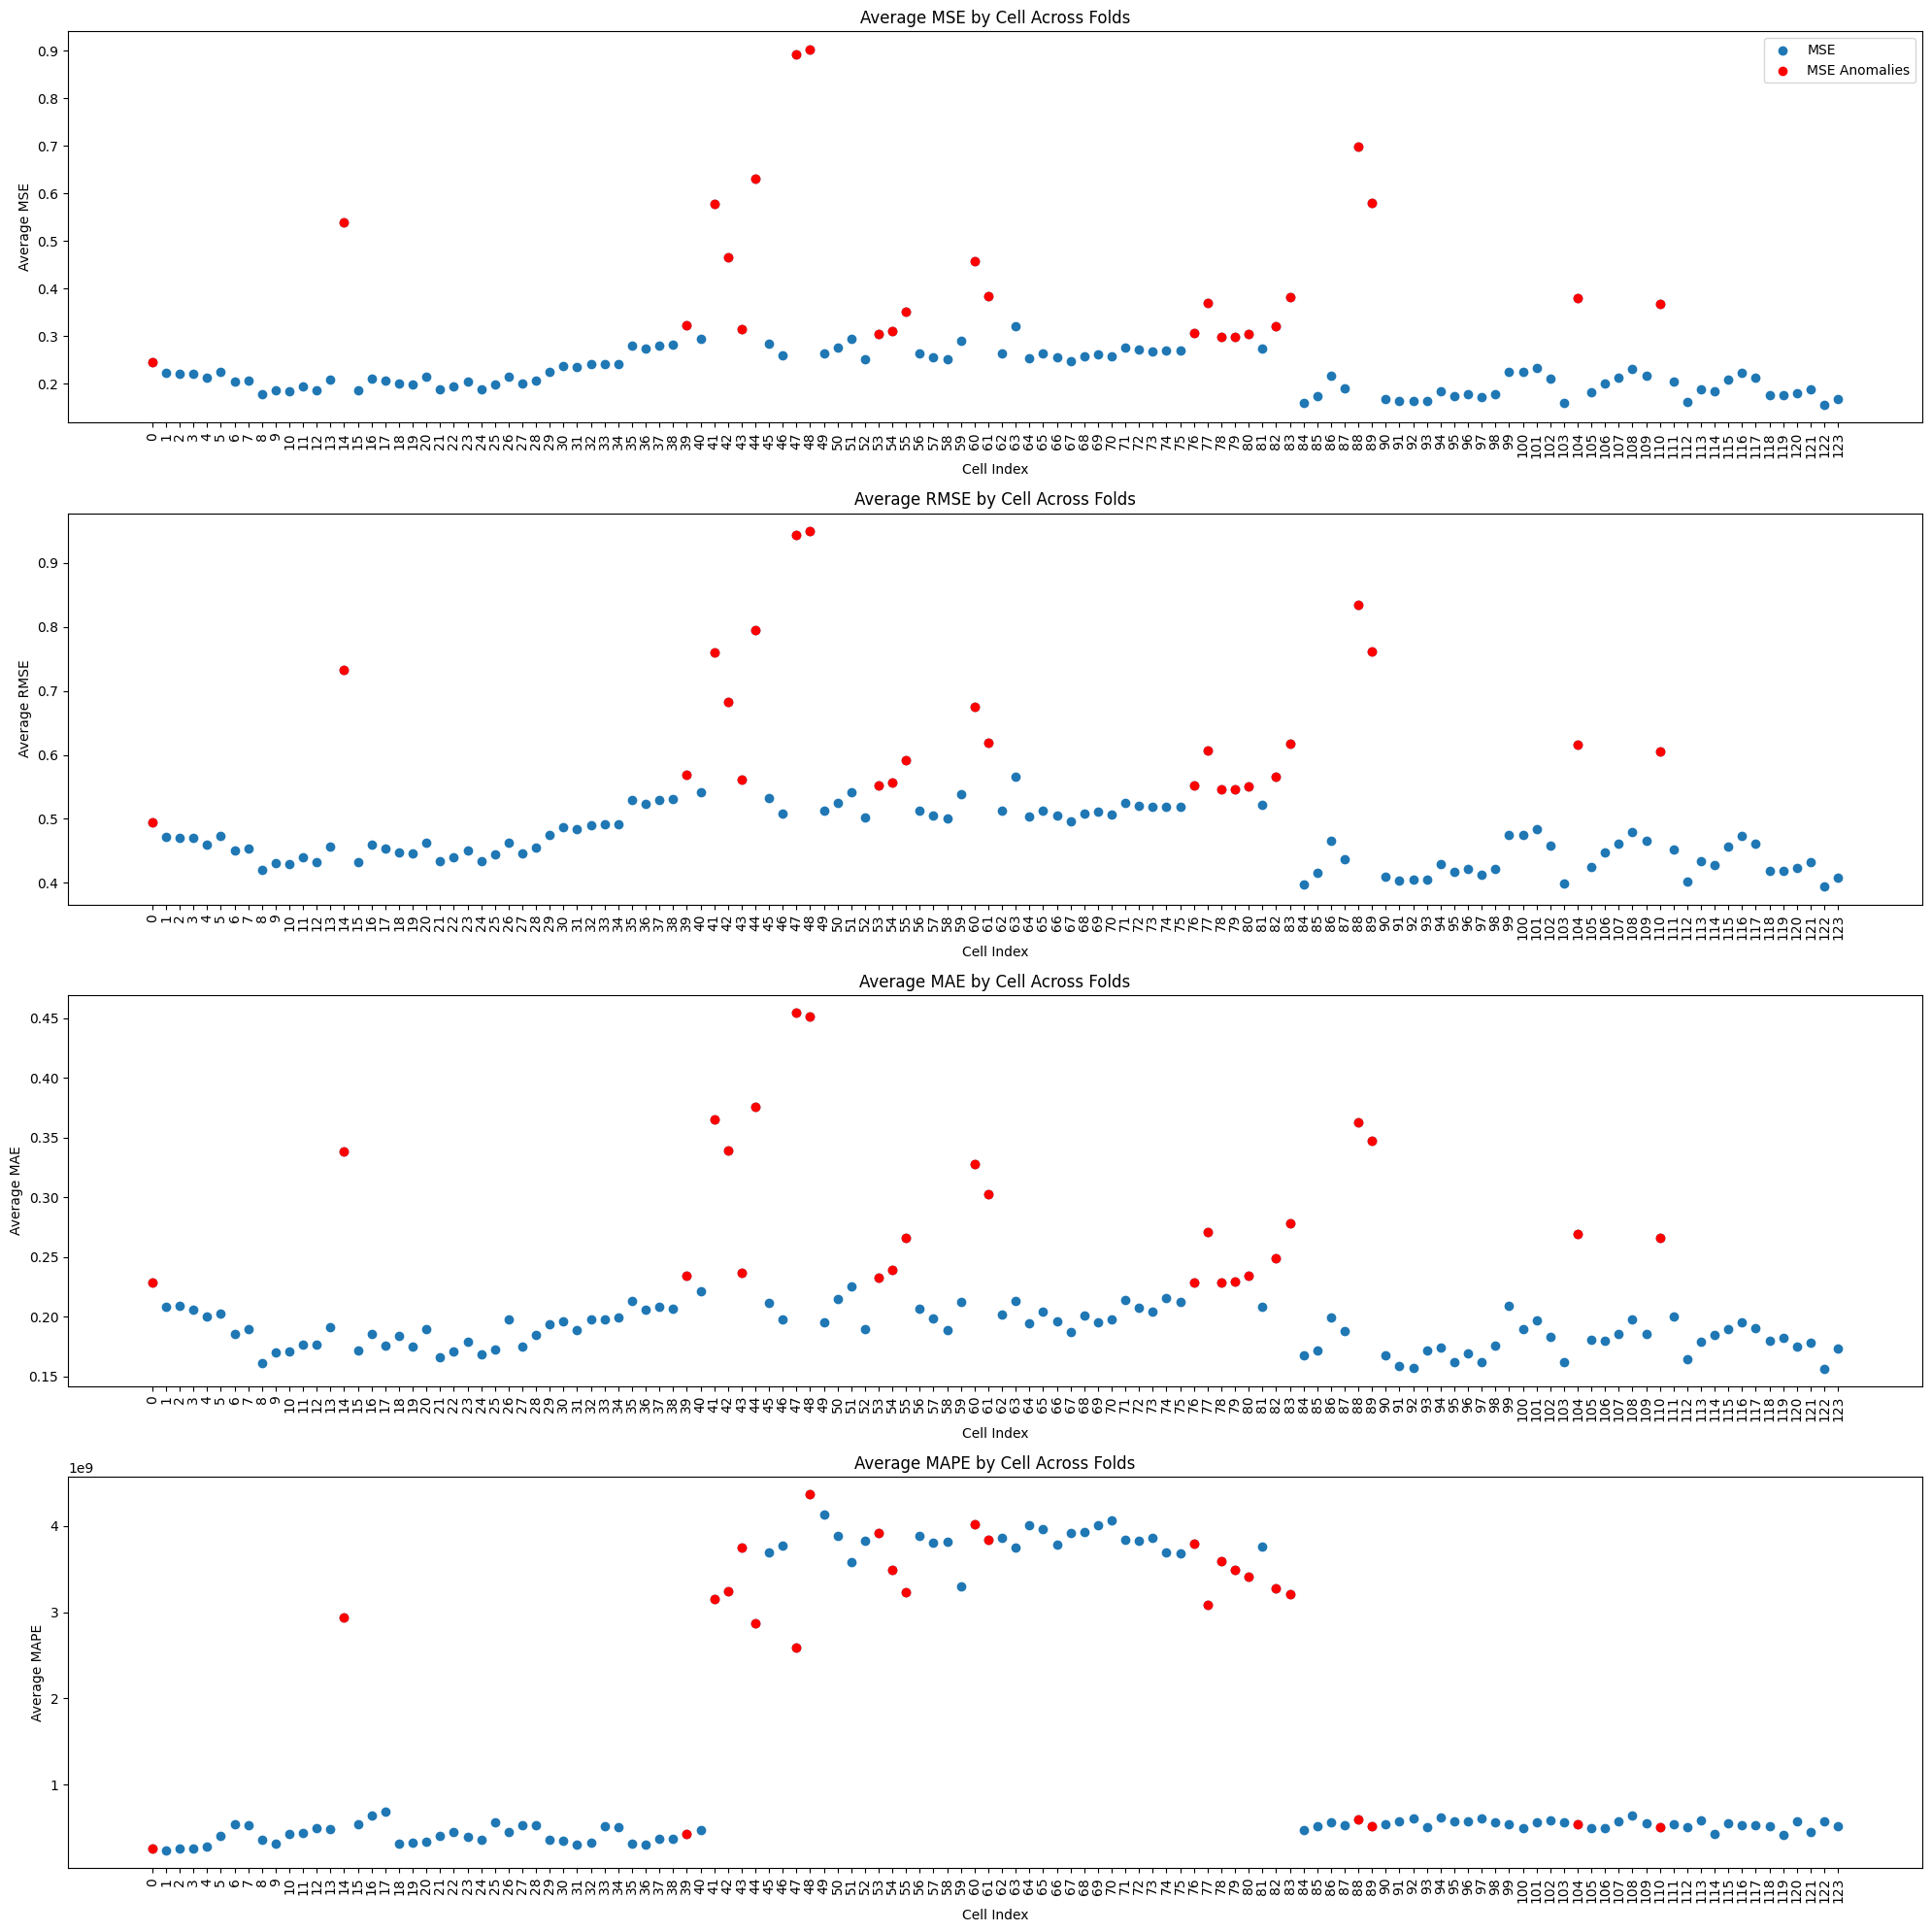

In [20]:
cae_v1_average_error_metrics_by_cells = cae_v1.evaluate()
anomaly_detector_cae_v1= AnomalyDetector()
anomalies_cae_v1, metric_errors_cae_v1 = anomaly_detector_cae_v1.detect_anomalies(cae_v1_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v1)
anomaly_detector_cae_v1.visual(cae_v1_average_error_metrics_by_cells, anomalies_cae_v1)

[43 46 48 49 50 52 53 56 57 58 60 61 62 64 65 66 67 68 69 70 71 72 73 76
 81]


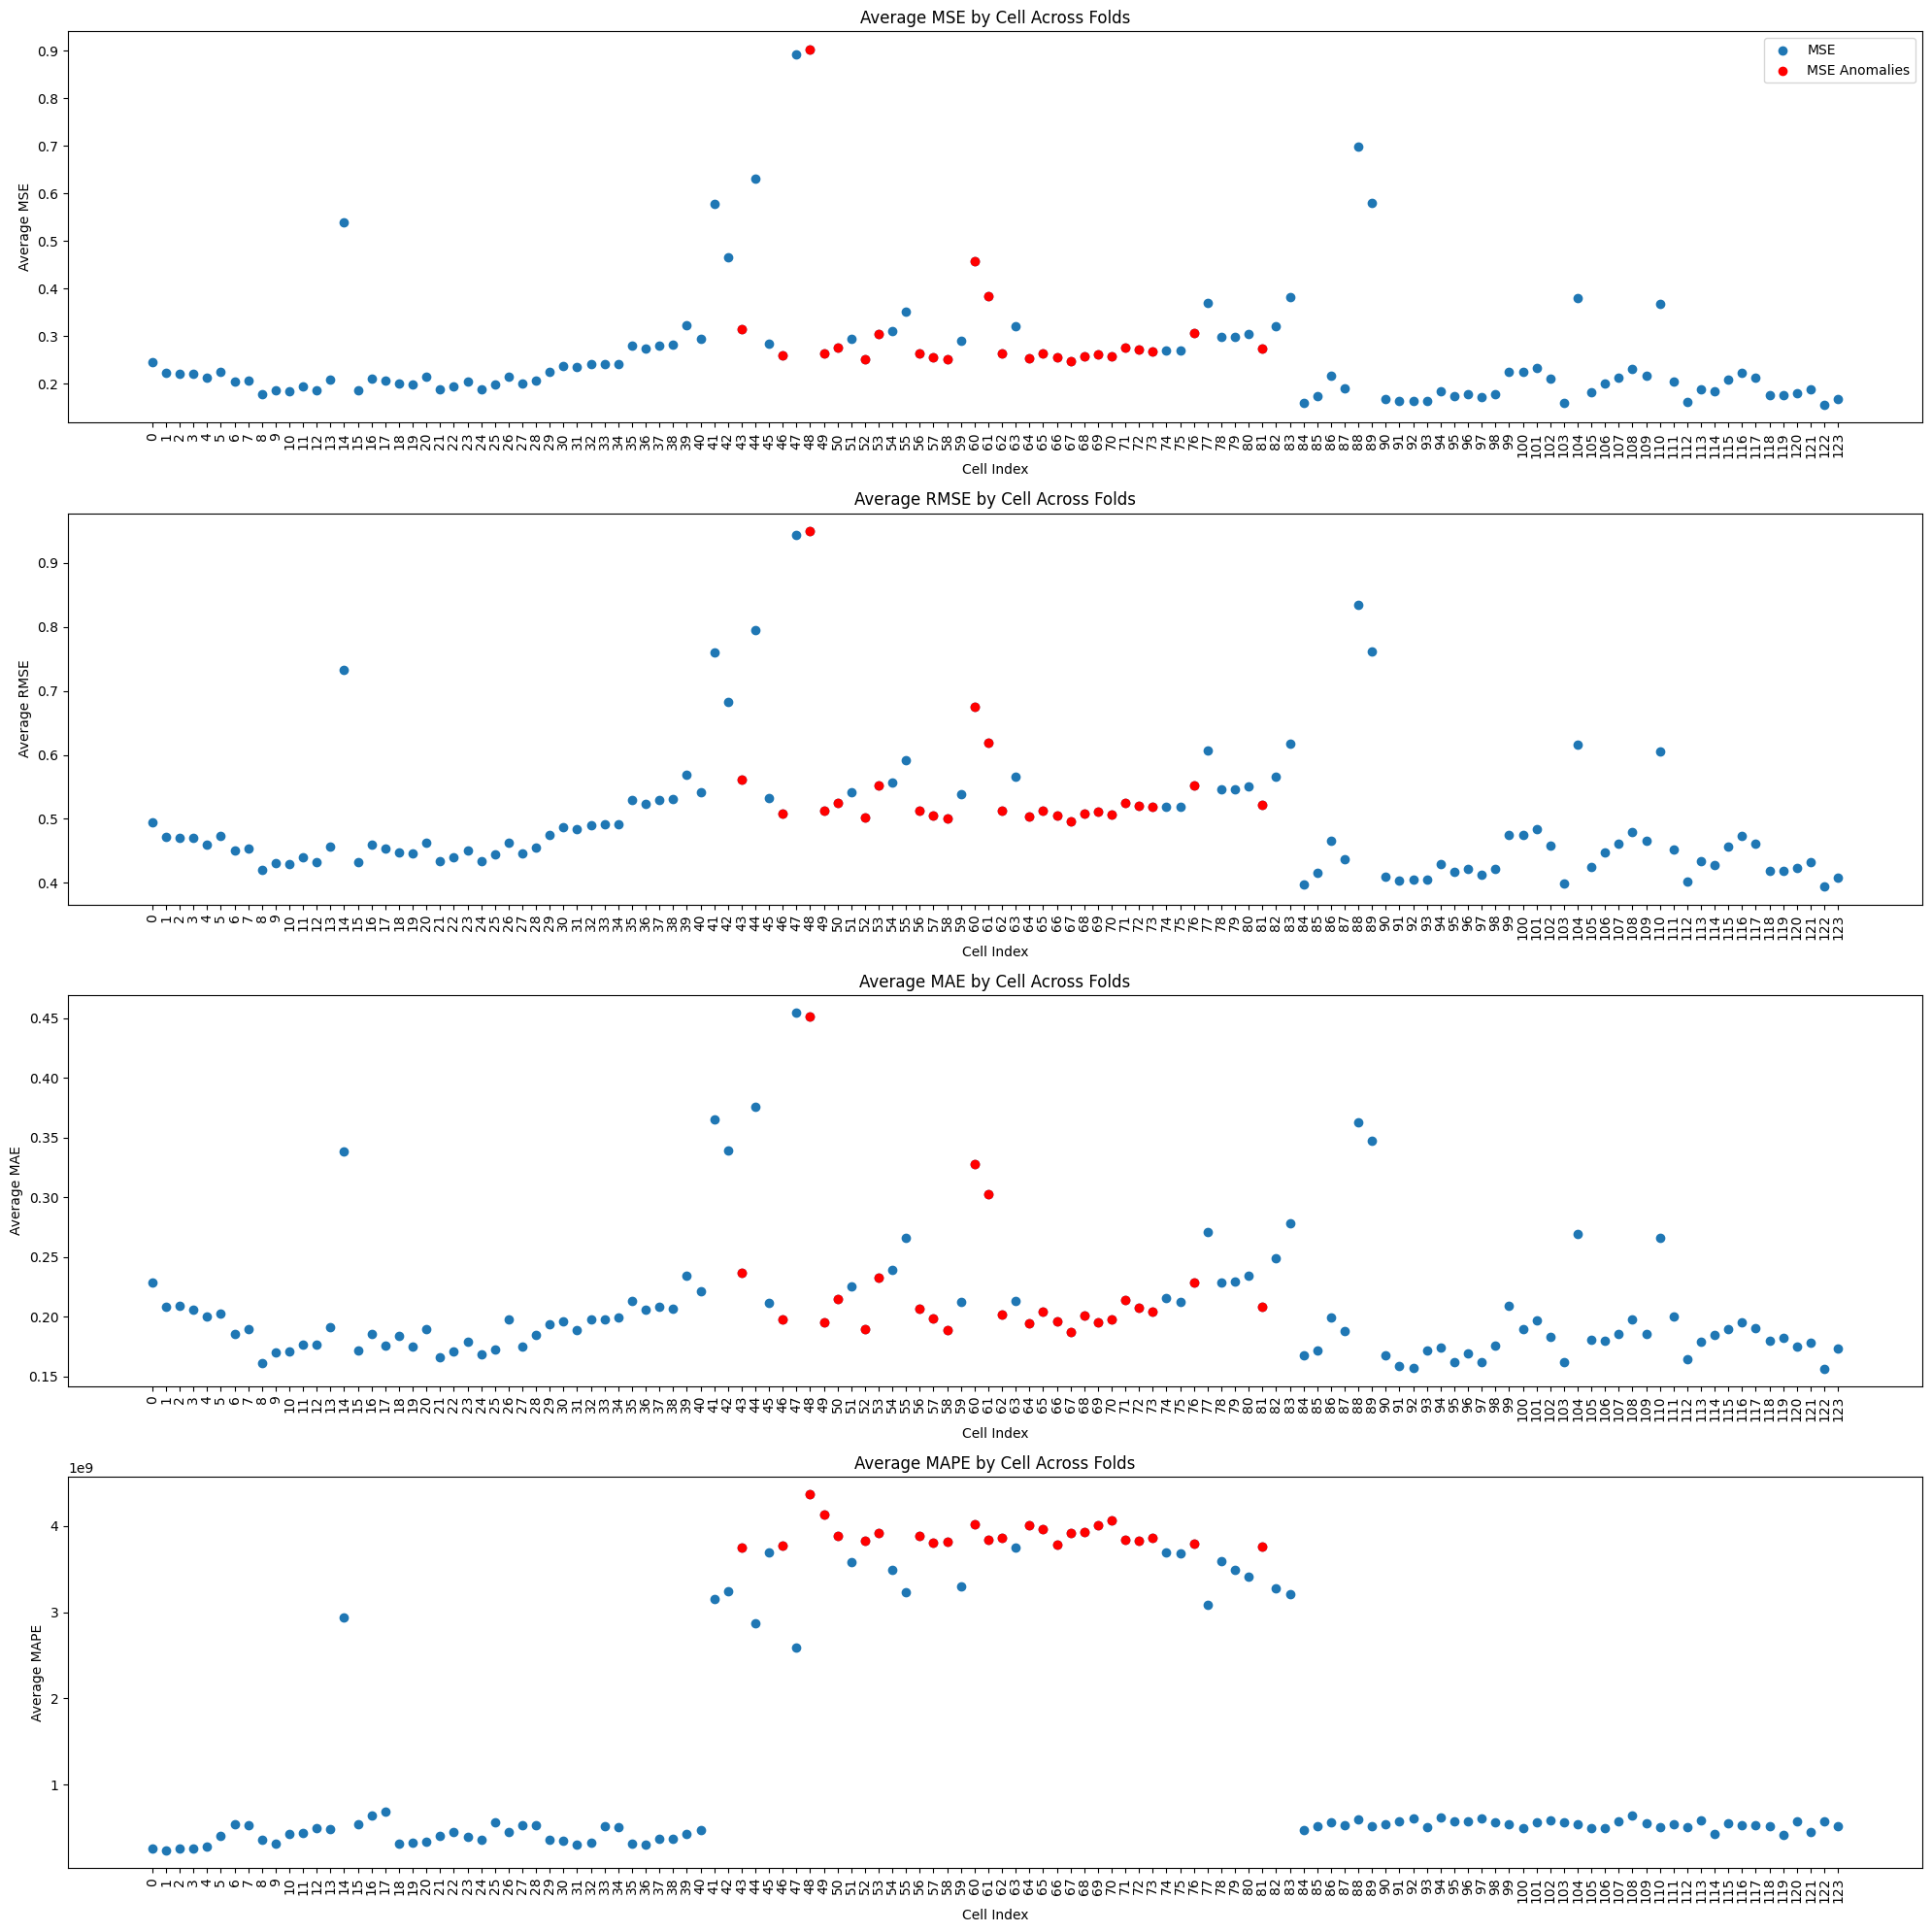

In [21]:
anomalies_cae_v1, metric_errors_cae_v1 = anomaly_detector_cae_v1.detect_anomalies(cae_v1_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v1)
anomaly_detector_cae_v1.visual(cae_v1_average_error_metrics_by_cells, anomalies_cae_v1)

In [22]:
cae_v2_ae, cae_v2_encoder = create_cae_v2(1000, 8)
cae_v2 = AutoencoderTrainer(base_dir, 'create_cae_v2_t1', batdata, cae_v2_ae)

no_of_timeseries: 1000
no_of_features: 8


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cae_v2_ae, to_file='cae_v2_ae_architecture.png', show_shapes=True, show_layer_names=True)

In [47]:
cae_v2_ae.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 1000, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1000, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 100, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 100, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 10, 8)          │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 10, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_12 (UpSampling1D) │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 10, 8)          │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 10, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_13 (UpSampling1D) │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 100, 8)         │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 100, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_14 (UpSampling1D) │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1000, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1000, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,080 (15.94 KB)

 Trainable params: 3,984 (15.56 KB)

 Non-trainable params: 96 (384.00 B)

In [23]:
cae_v2.train(learning_rate = 0.0001, batch_size=64, max_epoch=300, no_patience=20)

100%|██████████| 300/300 [05:47<00:00,  1.16s/epoch, loss=0.0332, mae=0.0984, mape=225, rmse=0.182]


In [80]:
cae_v2_average_error_metrics_by_cells = cae_v2.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.7808310985565186 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[ 14  41  42  43  44  45  47  48  50  51  53  54  55  60  61  76  77  78
  79  80  82  83  88  89 104]


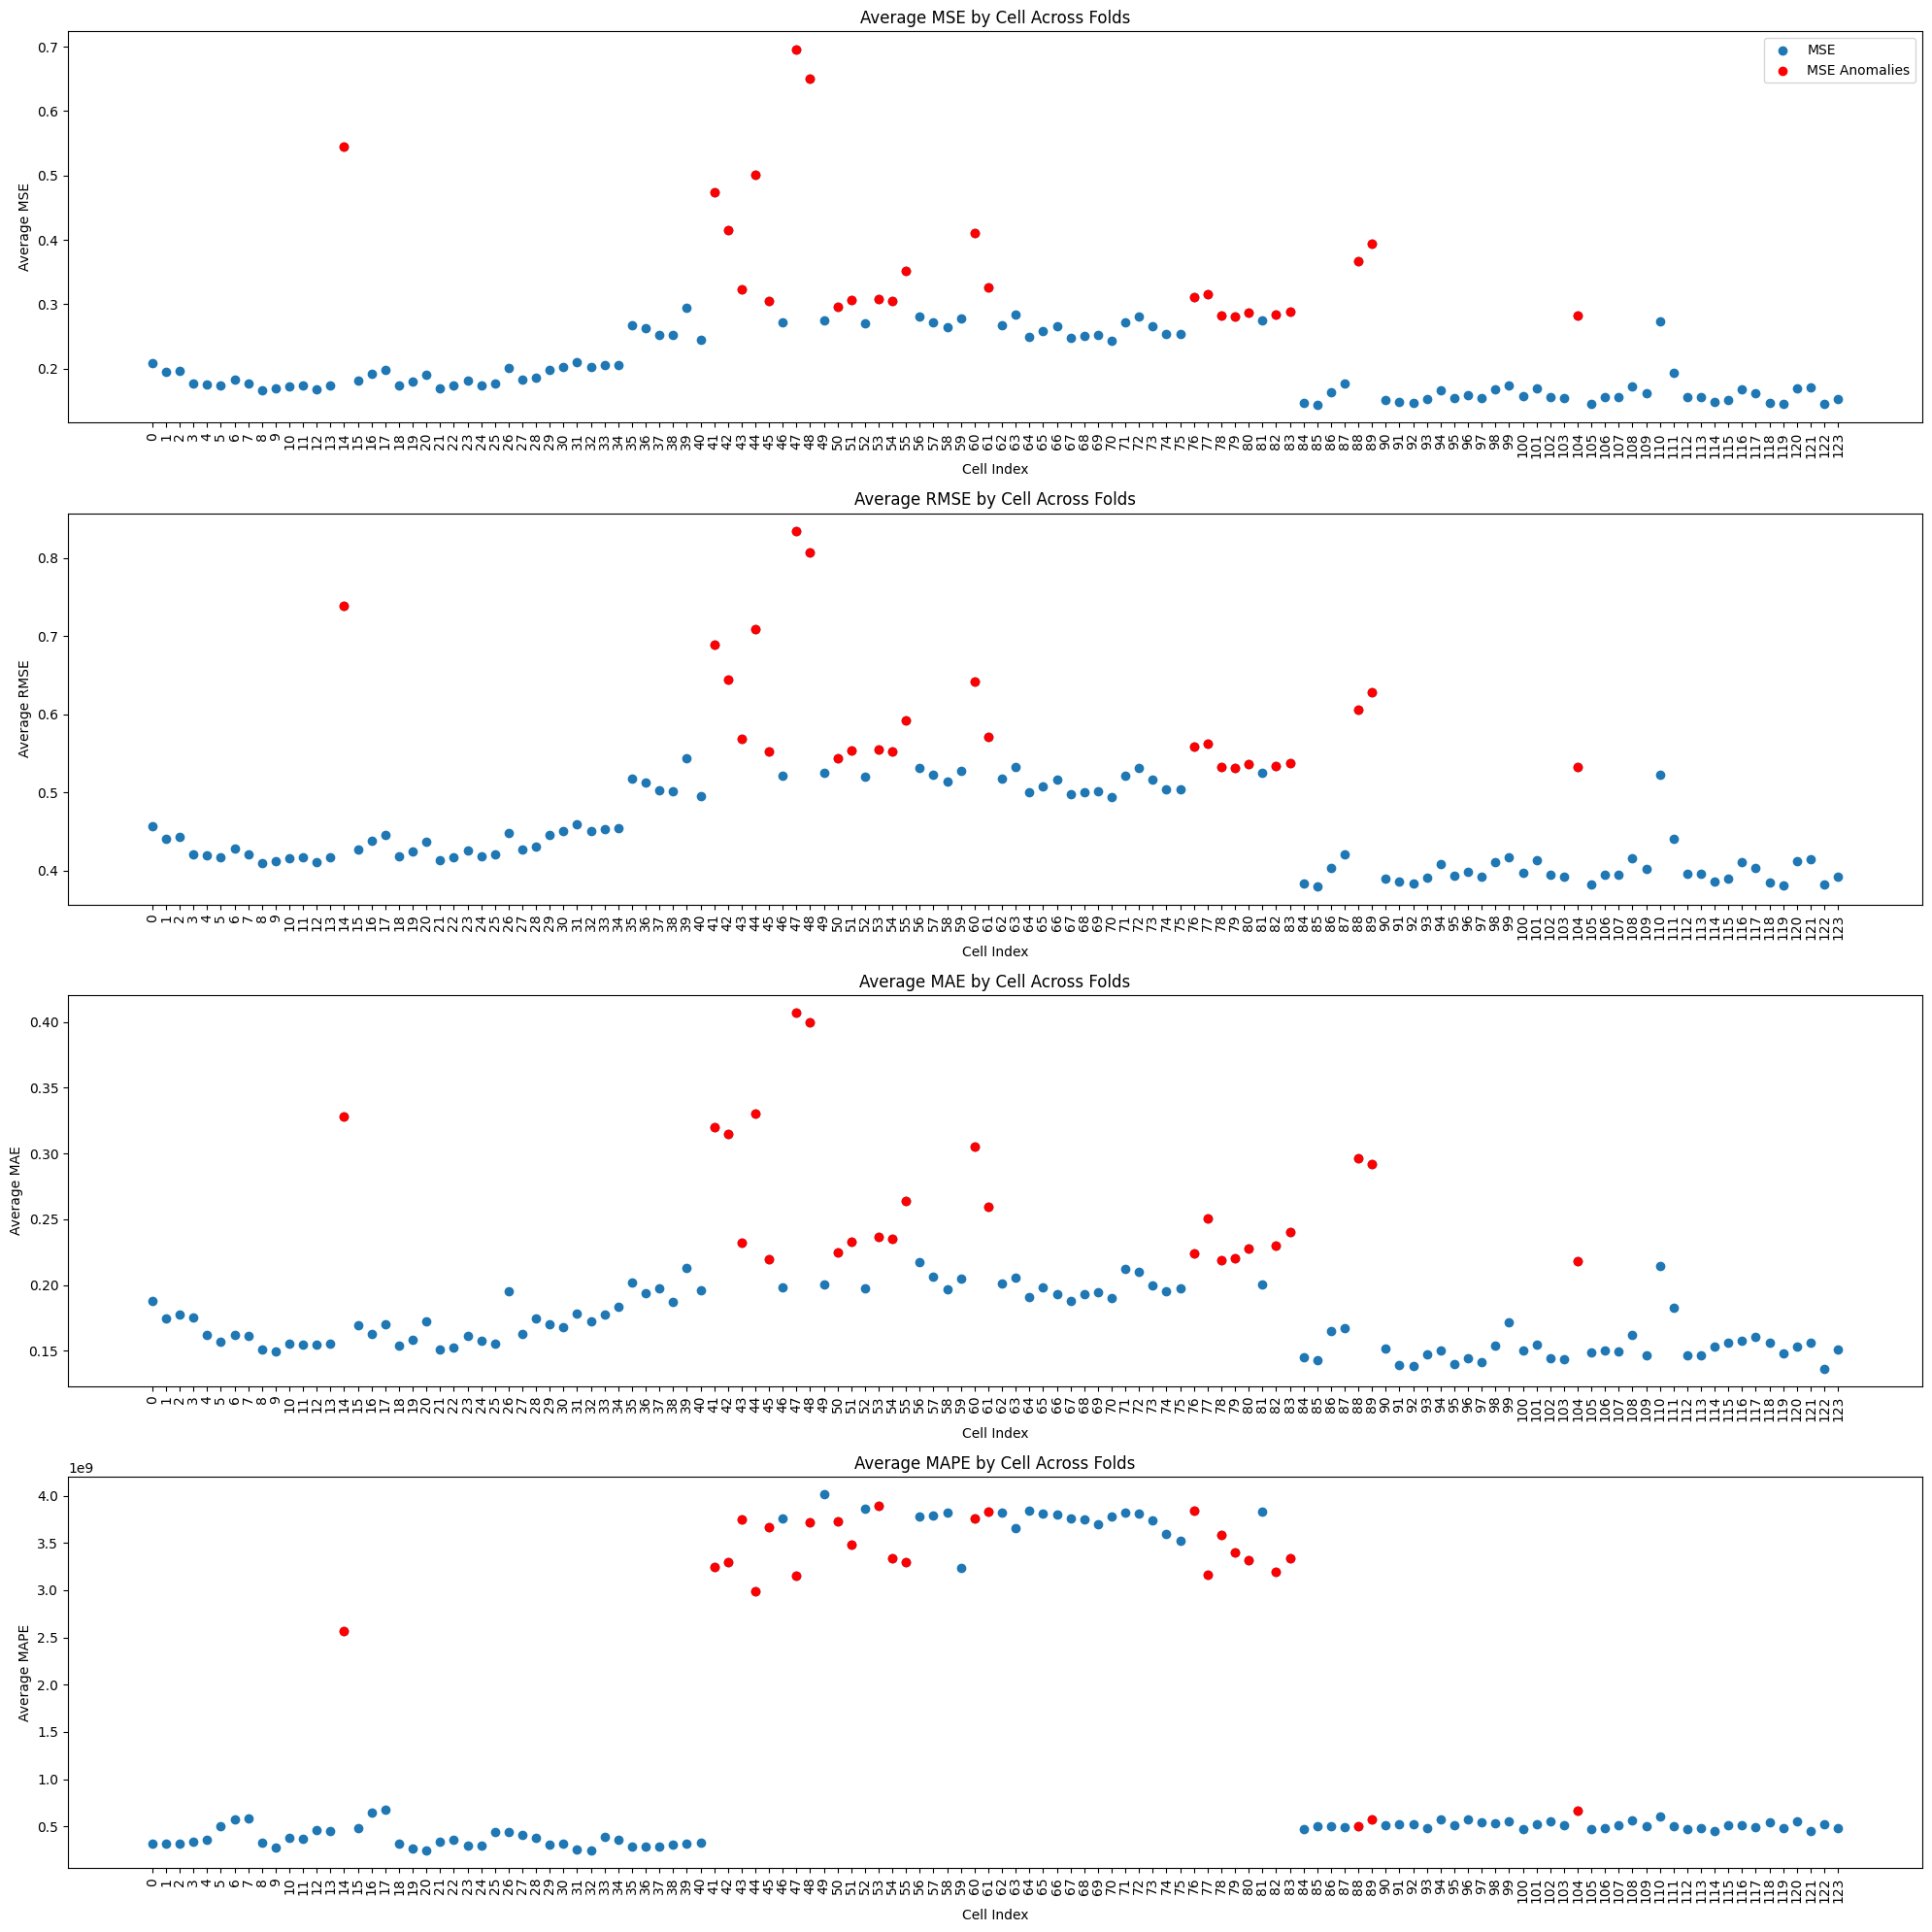

In [24]:

anomaly_detector_cae_v2= AnomalyDetector()
anomalies_cae_v2, metric_errors_cae_v2 = anomaly_detector_cae_v2.detect_anomalies(cae_v2_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v2)
anomaly_detector_cae_v2.visual(cae_v2_average_error_metrics_by_cells, anomalies_cae_v2)

[43 46 48 49 50 52 53 56 57 58 60 61 62 64 65 66 67 68 69 70 71 72 73 76
 81]


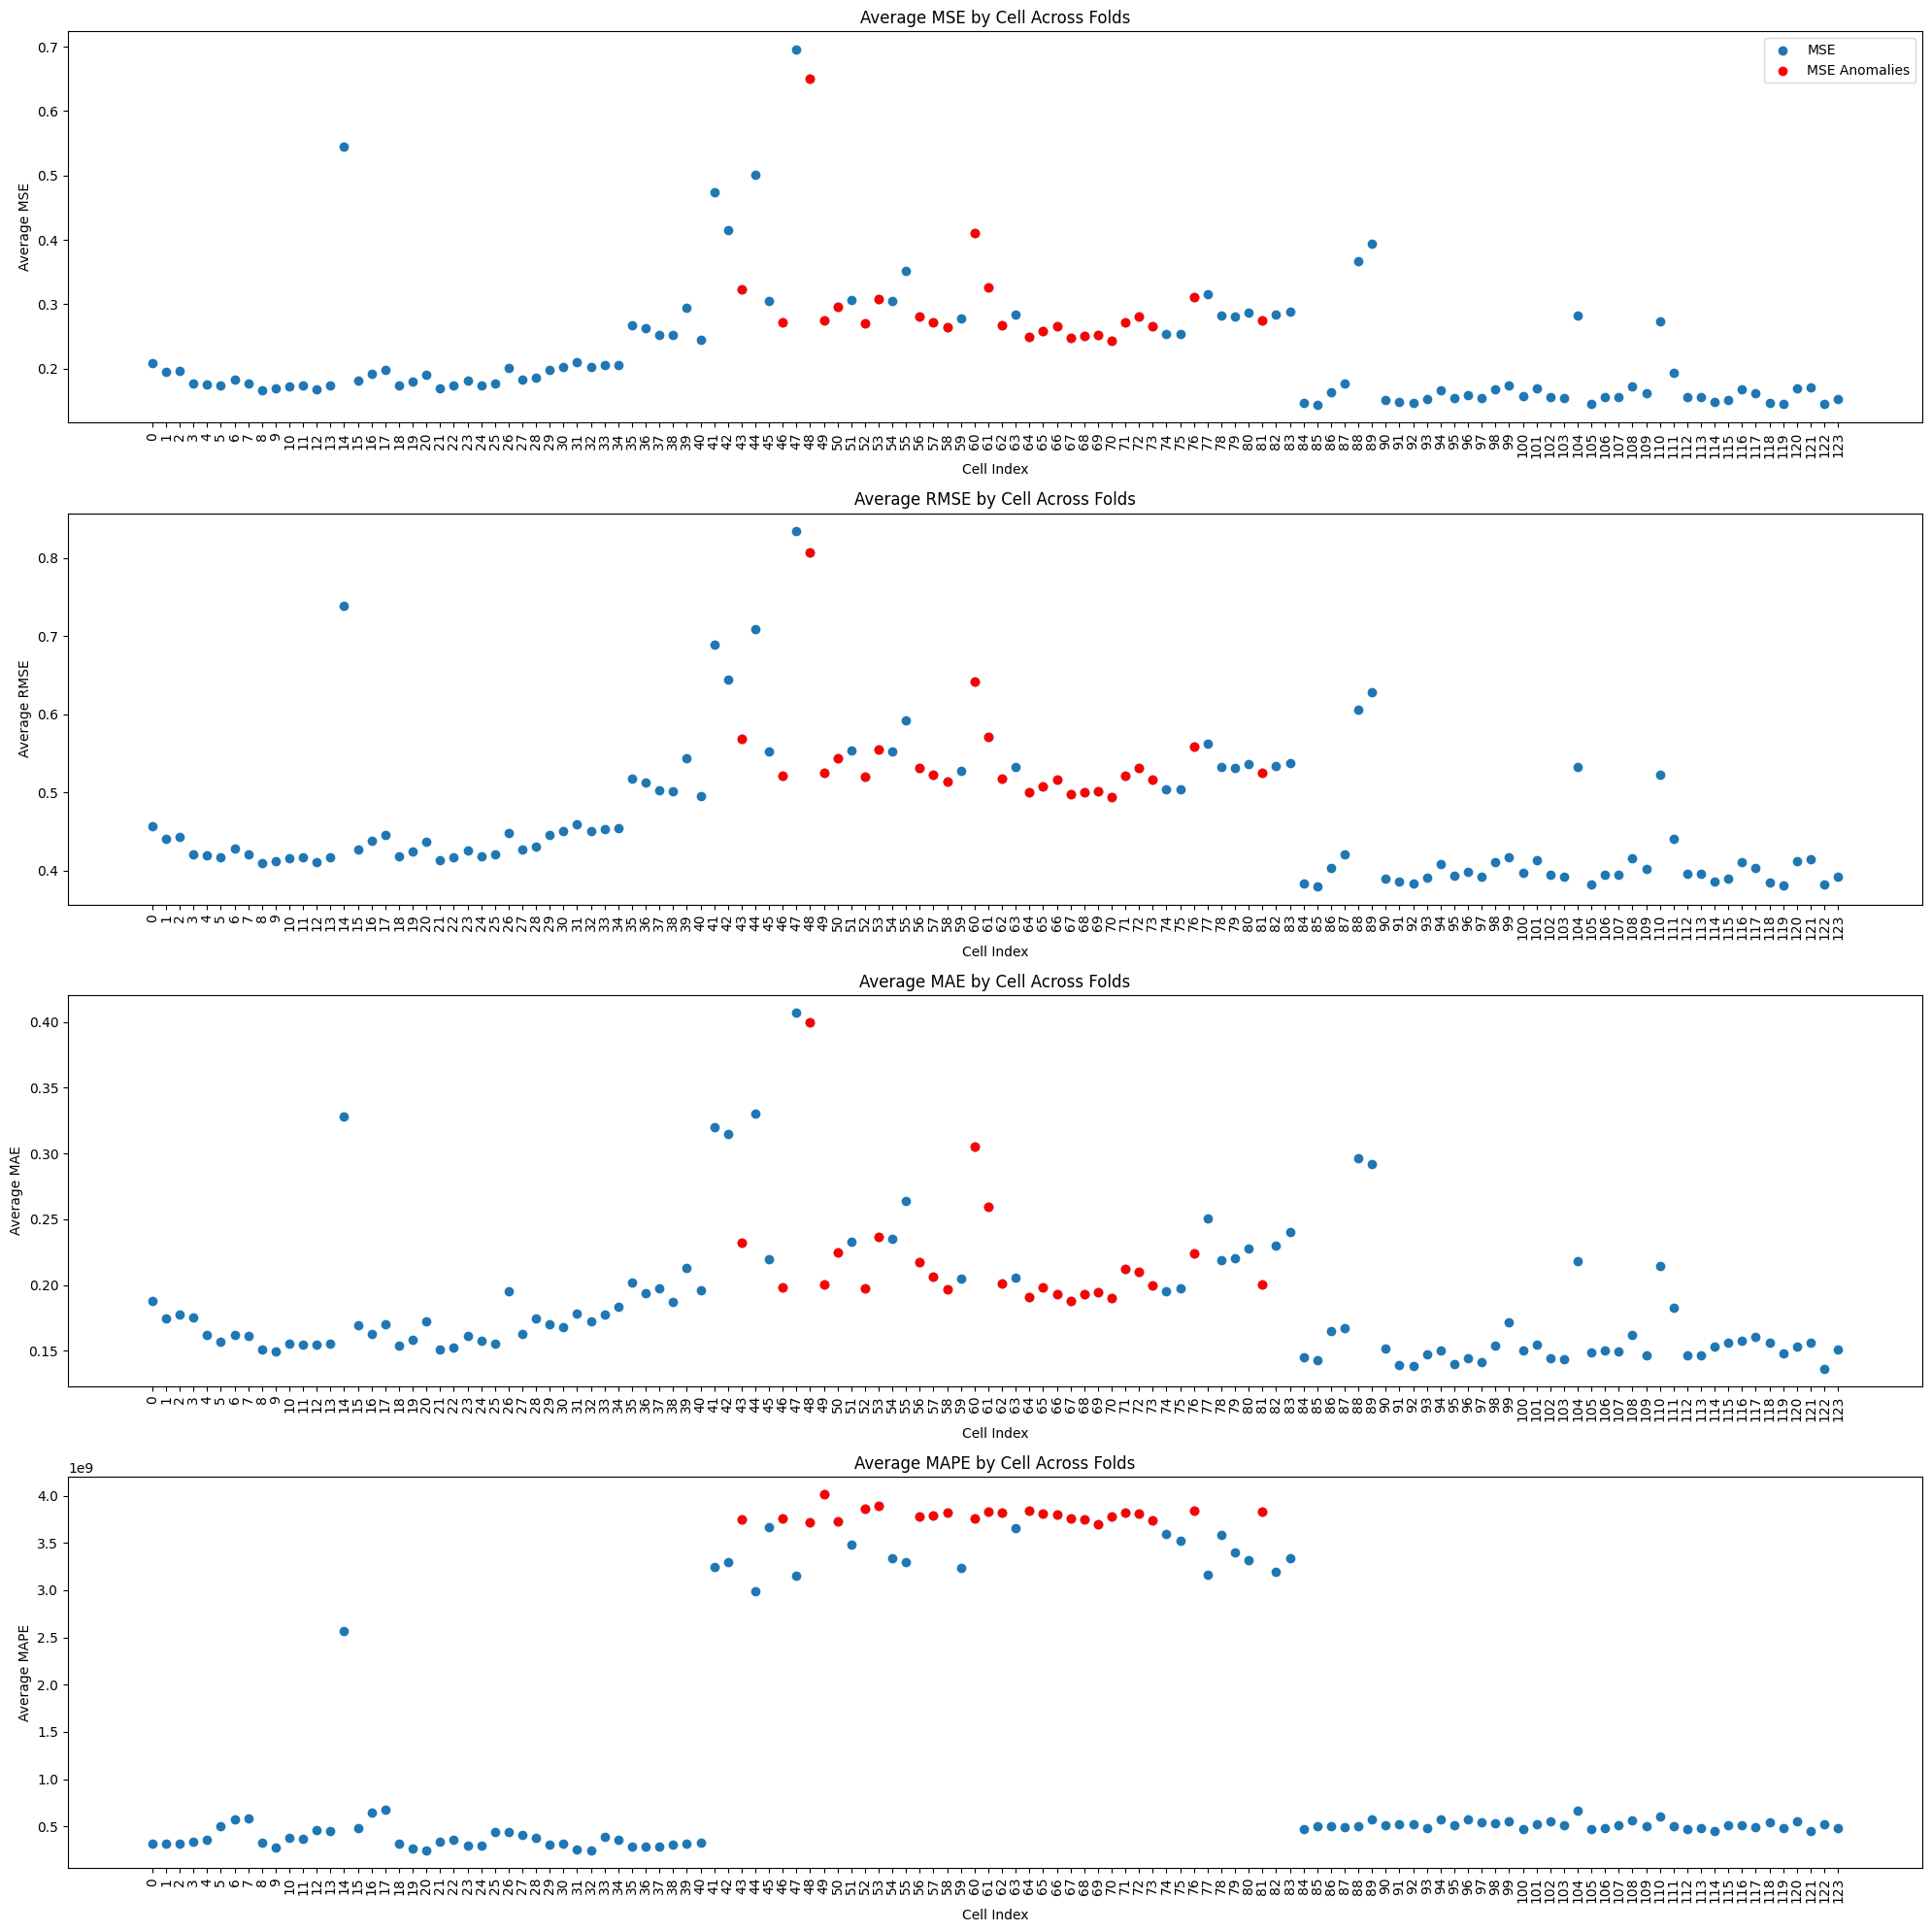

In [25]:
anomalies_cae_v2, metric_errors_cae_v2 = anomaly_detector_cae_v2.detect_anomalies(cae_v2_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v2)
anomaly_detector_cae_v2.visual(cae_v2_average_error_metrics_by_cells, anomalies_cae_v2)

In [14]:
cae_v3_ae, cae_v3_encoder = create_cae_v3(1000, 8)
cae_v3 = AutoencoderTrainer(base_dir, 'create_cae_v3_t1', batdata, cae_v3_ae)

no_of_timeseries: 1000
no_of_features: 8


In [15]:
cae_v3_ae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1000, 128)      │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 100, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 100, 64)        │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 10, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 10, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 1, 32)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1000, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 223,960 (874.84 KB)

 Trainable params: 223,064 (871.34 KB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cae_v3_ae, to_file='cae_v3_ae.png', show_shapes=True, show_layer_names=True)


"dot" with args ['-Tpng', '/tmp/tmp0t0s067z/tmpsrzhzcxp'] returned code: -6

stdout, stderr:
 b''
b"newtrap: Trapezoid-table overflow 441\ndot: trapezoid.c:84: newtrap: Assertion `0' failed.\n"



AssertionError: "dot" with args ['-Tpng', '/tmp/tmp0t0s067z/tmpsrzhzcxp'] returned code: -6

In [45]:
cae_v3_ae.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 1000, 128)      │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_9             │ (None, 100, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 100, 64)        │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_10            │ (None, 10, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 10, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_11            │ (None, 1, 32)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 1, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_9 (UpSampling1D)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 10, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_10 (UpSampling1D) │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_11 (UpSampling1D) │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 1000, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 223,960 (874.84 KB)

 Trainable params: 223,064 (871.34 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
cae_v3.train(learning_rate = 0.0001, batch_size=64, max_epoch=300, no_patience=20)

In [115]:
cae_v3_average_error_metrics_by_cells = cae_v3.evaluate()

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.6654539108276367 seconds


388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[  3  14  26  41  42  43  44  47  48  60  61  77  82  83  86  88 100 101
 107 108 109 110 115 116 117]


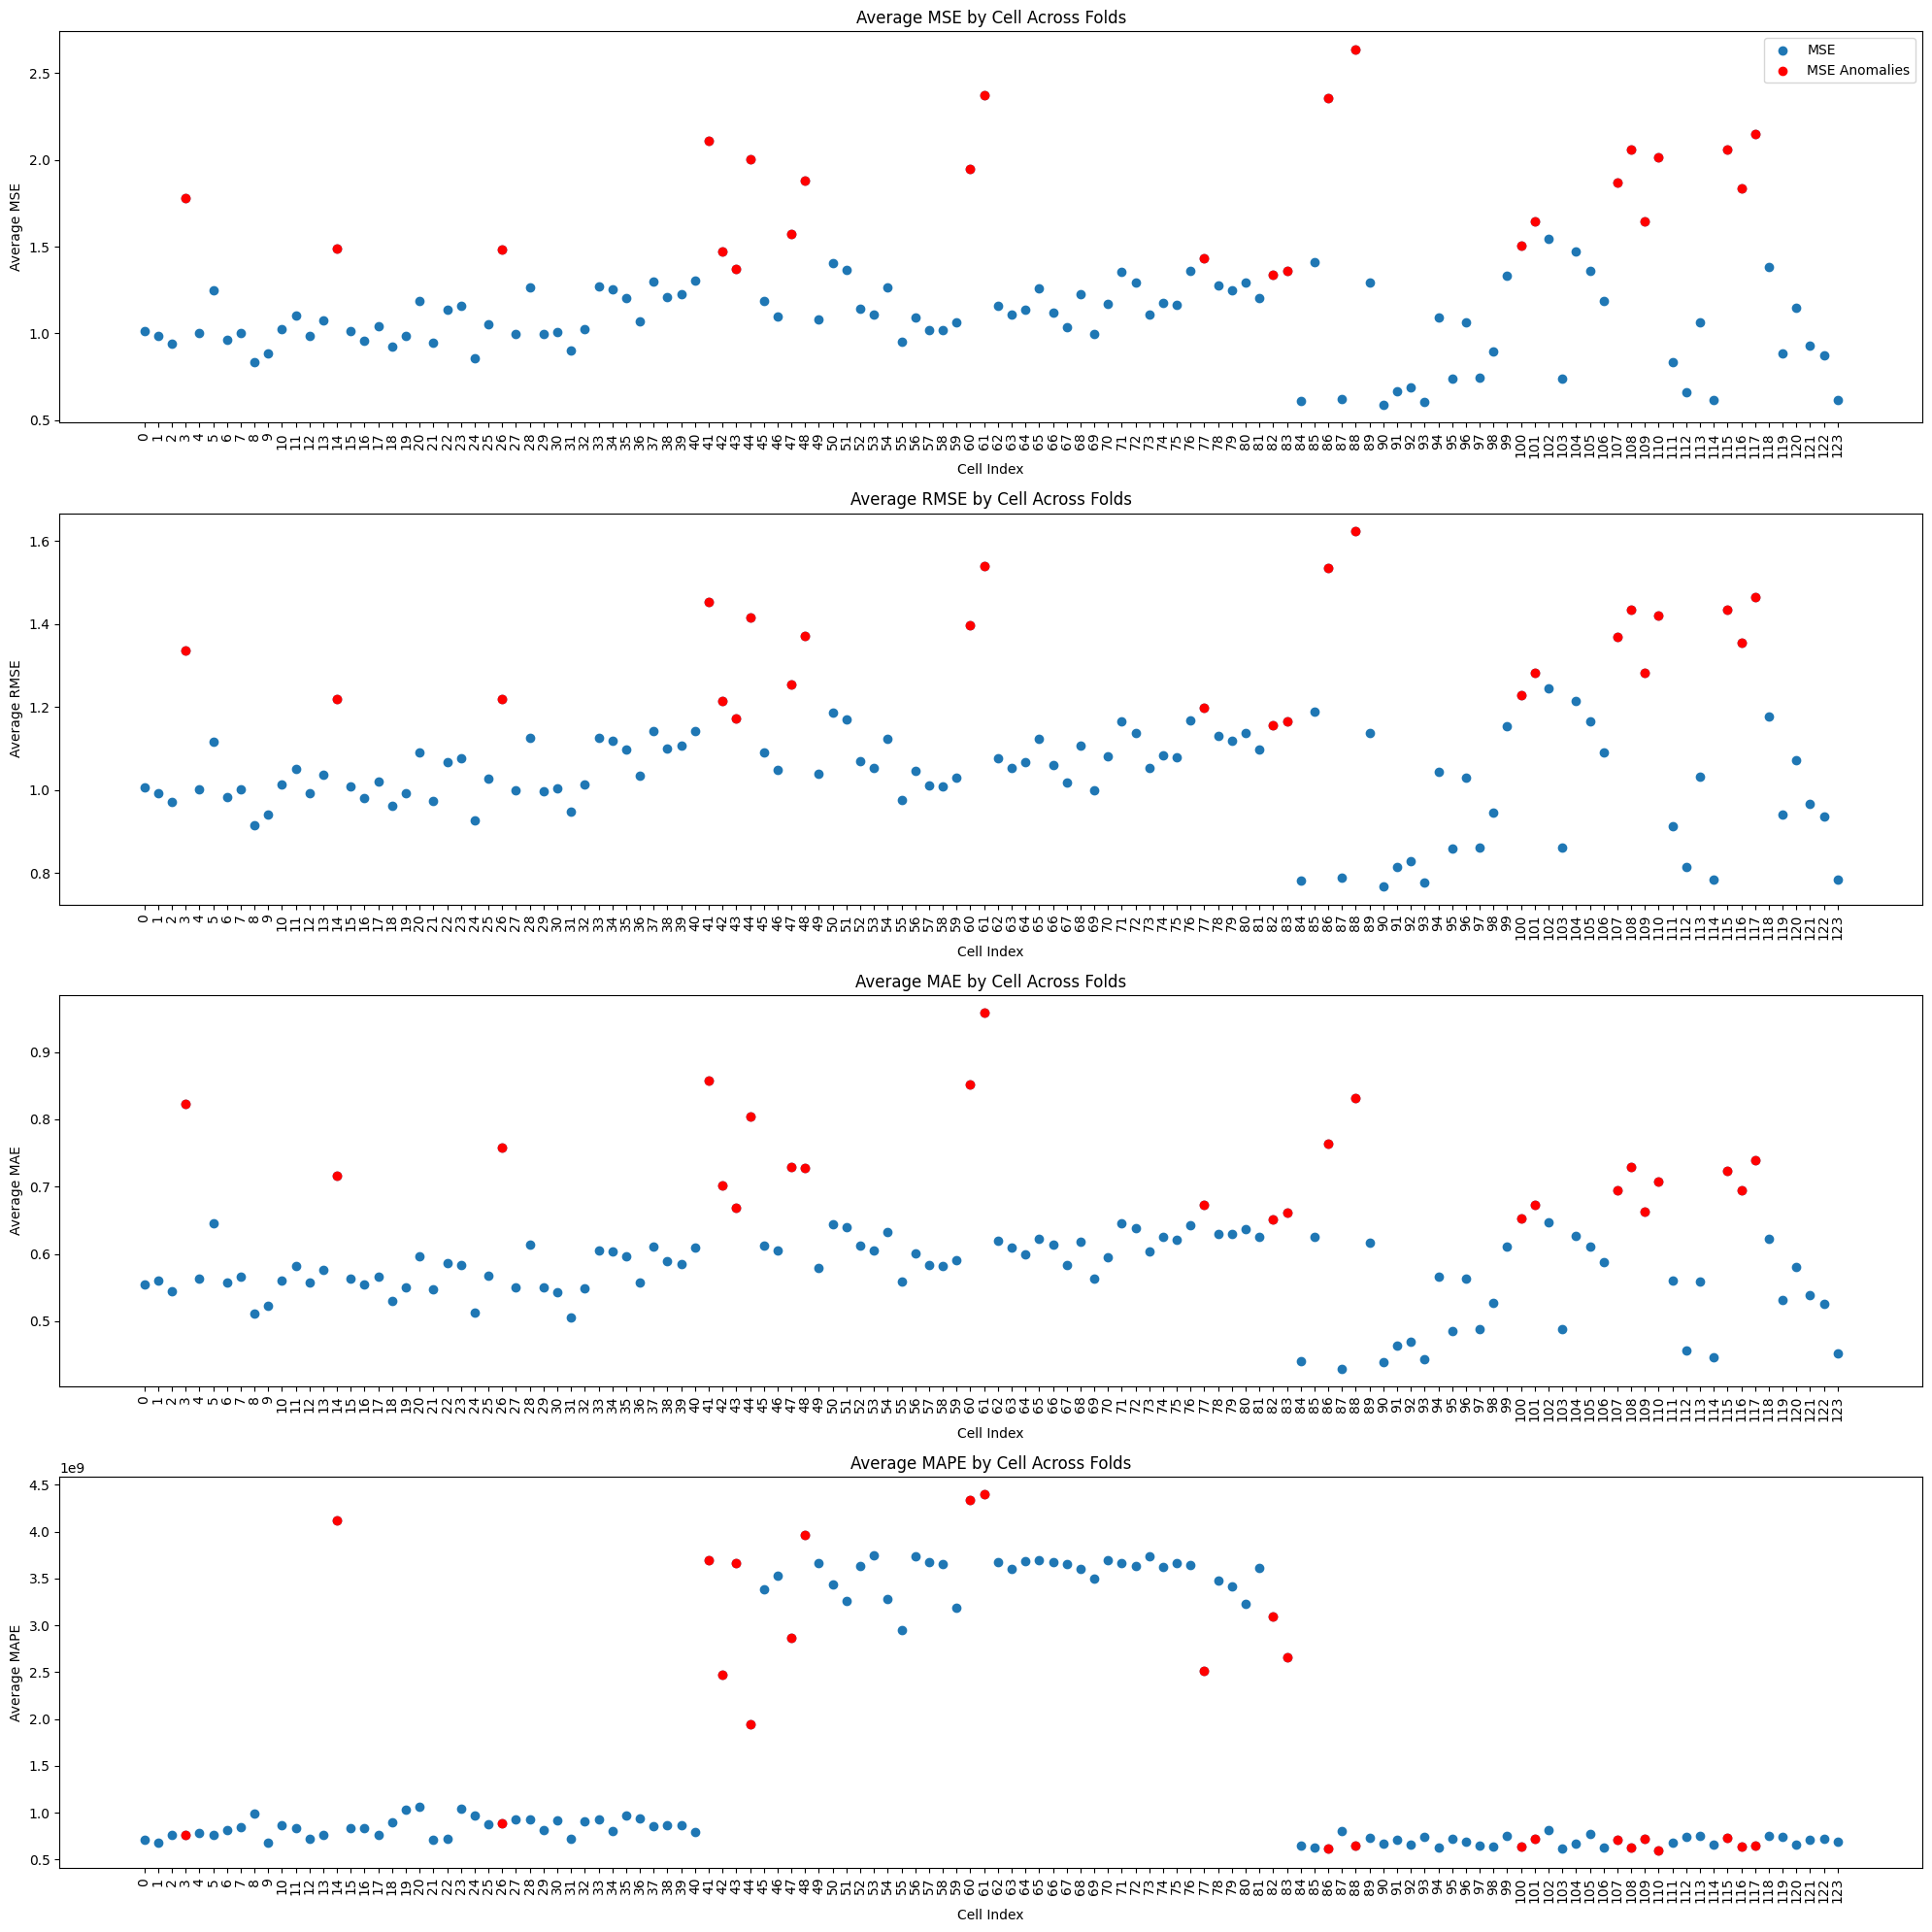

In [28]:
cae_v3_average_error_metrics_by_cells = cae_v3.evaluate()
anomaly_detector_cae_v3= AnomalyDetector()
anomalies_cae_v3, metric_errors_cae_v3 = anomaly_detector_cae_v3.detect_anomalies(cae_v3_average_error_metrics_by_cells, 
                                                                                             metric='mae', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v3)
anomaly_detector_cae_v3.visual(cae_v3_average_error_metrics_by_cells, anomalies_cae_v3)

[14 41 43 48 49 52 53 56 57 58 60 61 62 64 65 66 67 70 71 72 73 74 75 76
 81]


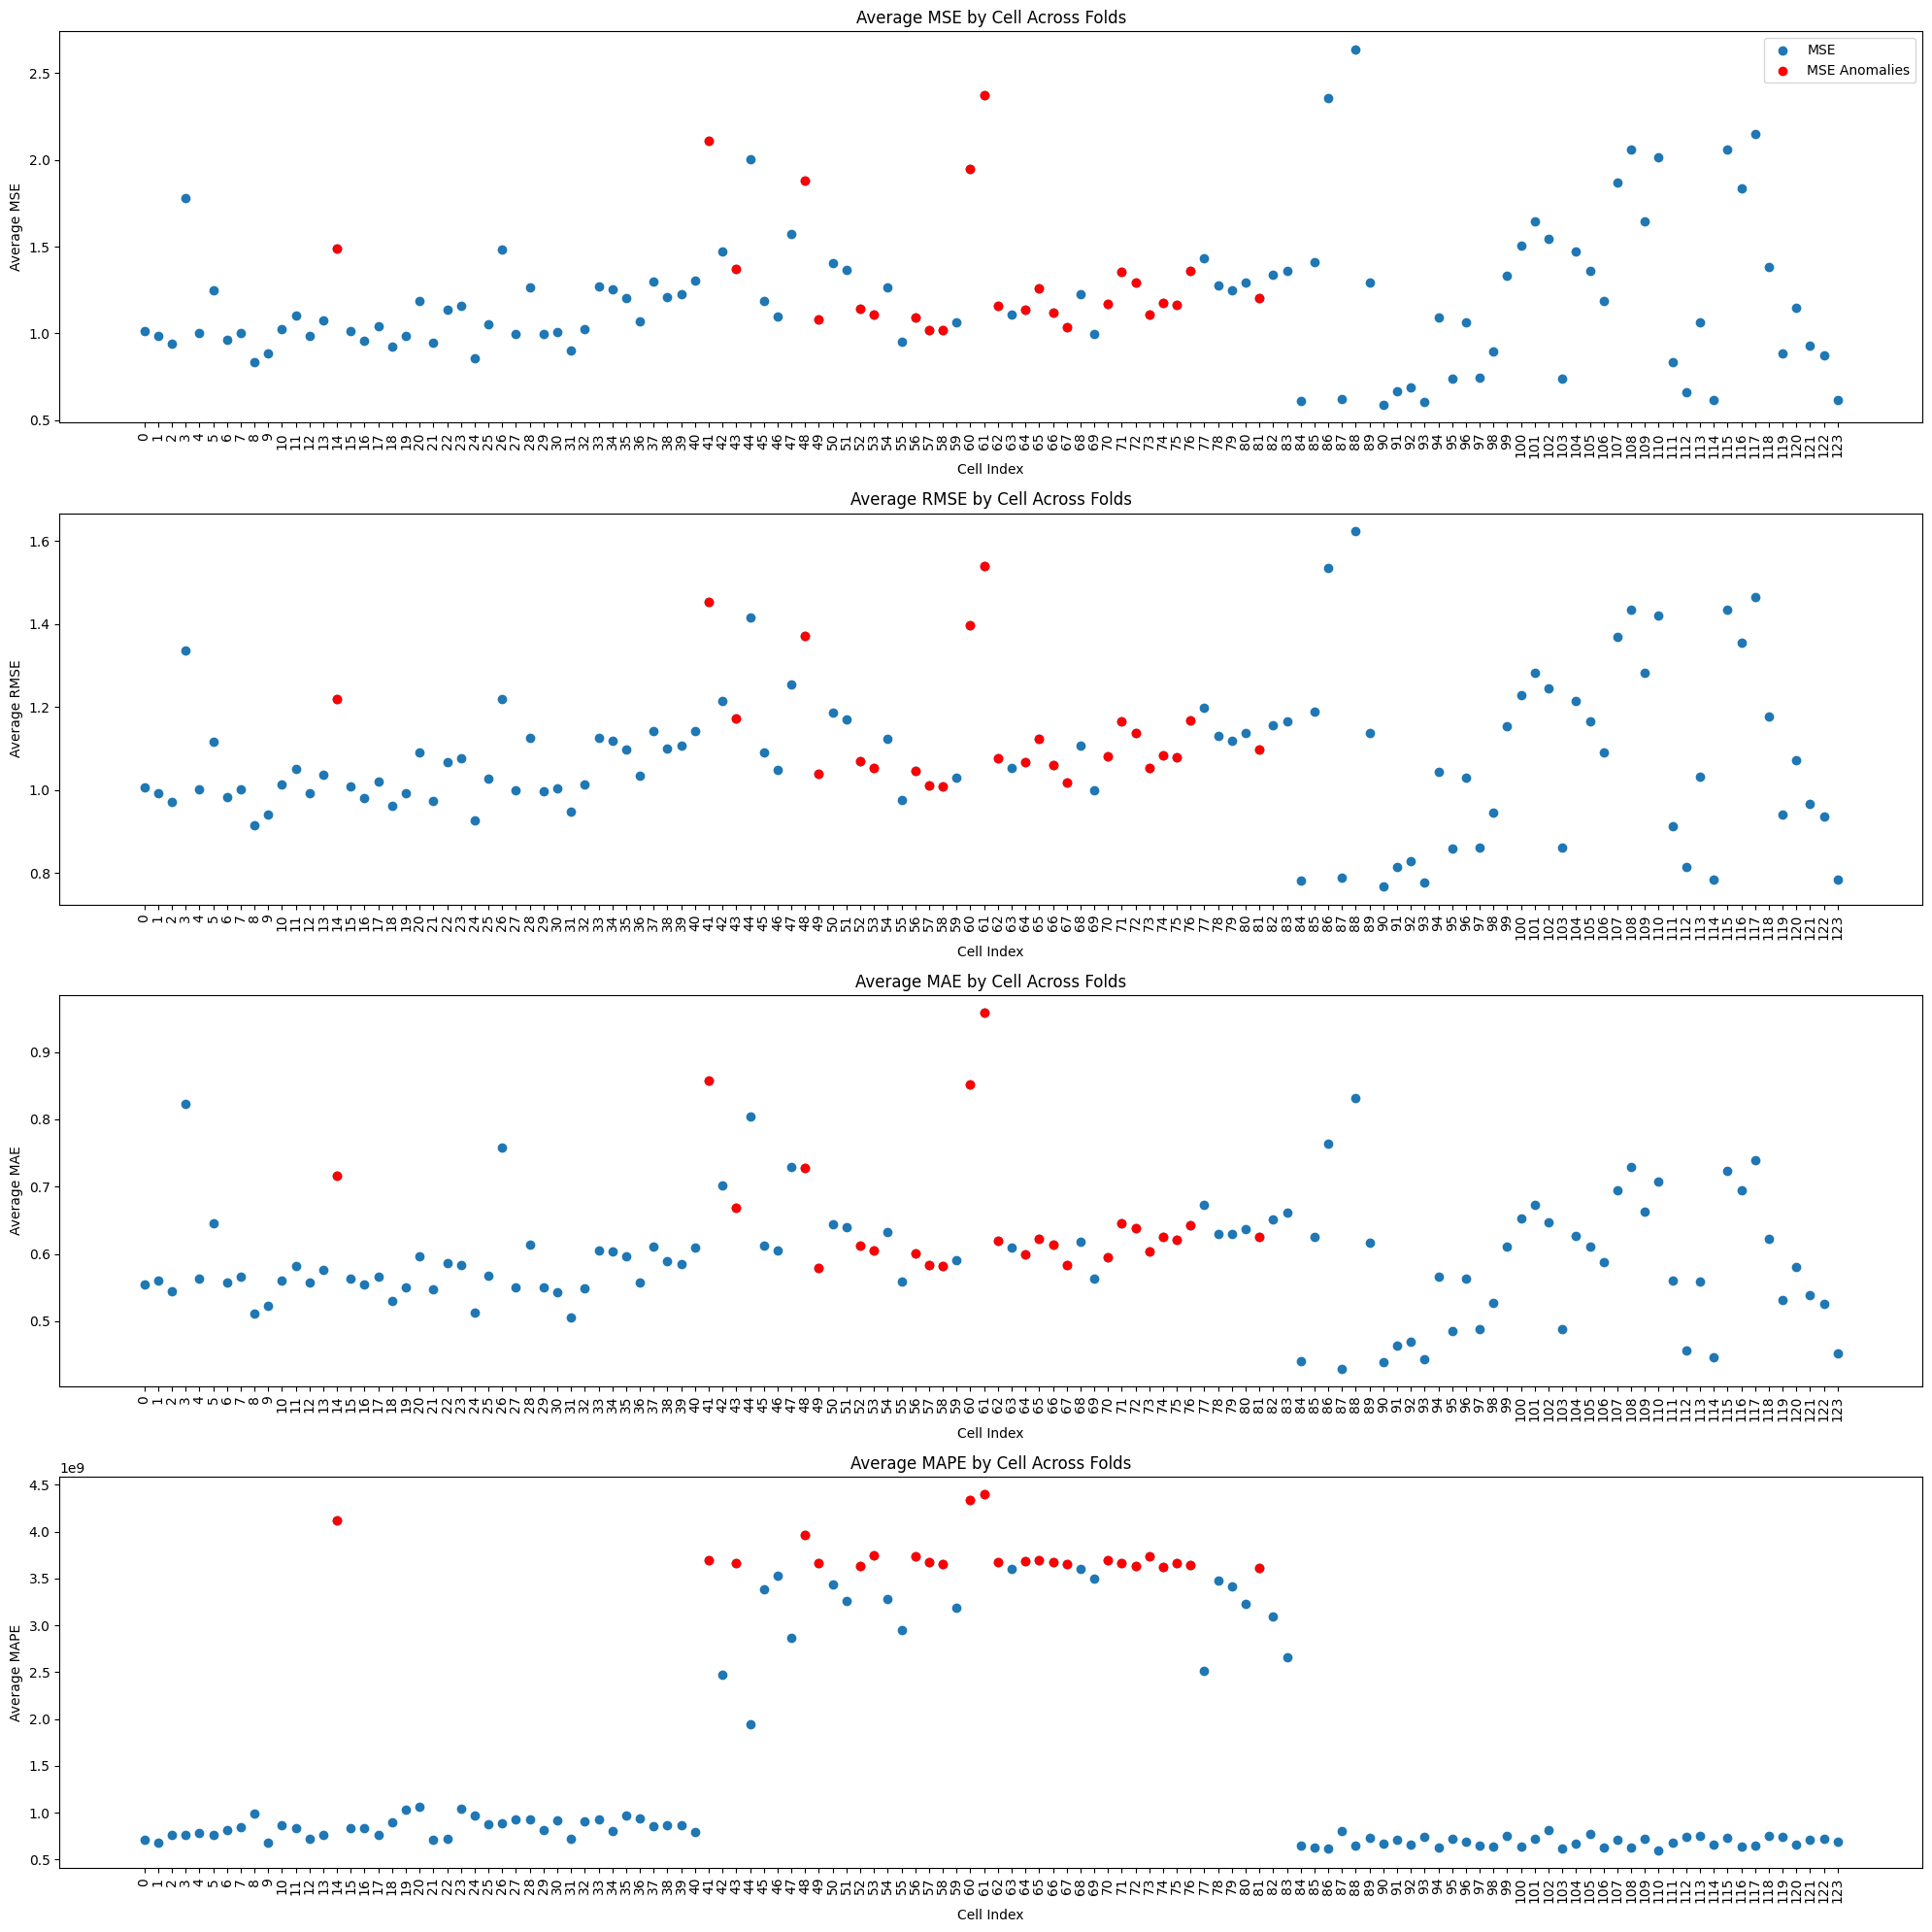

In [29]:
anomalies_cae_v3, metric_errors_cae_v3 = anomaly_detector_cae_v3.detect_anomalies(cae_v3_average_error_metrics_by_cells, 
                                                                                             metric='mape', 
                                                                                             threshold_function=AD.threshold_percentile,
                                                                                             threshold_value=80)
print(anomalies_cae_v3)
anomaly_detector_cae_v3.visual(cae_v3_average_error_metrics_by_cells, anomalies_cae_v3)